# Generation

Erik S. McGuire

CSC594-810-ADL, Winter 19-20

---
## I. Preliminaries
 > A. Imports\*

 > B. Data

---

 *<small>Required.</small>

### A. Imports
* Mount and navigate to Google Drive, import dependencies.

* Training in this notebook was mostly done on free tier GPU runtime with standard RAM.

> Mount drive if not automatically done when runtime reactivated (can also use sidepanel to the left):

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

> Install necessary libraries and dependencies:

In [ ]:
#Required over !pip install transformers for subclassing model/overriding methods.
!git clone https://github.com/huggingface/transformers.git
%cd transformers
!pip install .

> Install HuggingFace Transformers as our main library for training and generation with GPT-2.

In [ ]:
%tensorflow_version 2.x
from transformers import GPT2Tokenizer, GPT2DoubleHeadsModel, GPT2LMHeadModel, PreTrainedModel

> Subclass GPT-2 models to overwrite repetition penalty method so that it doesn't penalize punctuation.

In [ ]:
class GPT2DoubleHeadsModelRP(GPT2DoubleHeadsModel):
    def enforce_repetition_penalty_(self, lprobs, batch_size, num_beams, prev_output_tokens, repetition_penalty):
        """repetition penalty (from CTRL paper https://arxiv.org/abs/1909.05858). """
        for i in range(batch_size * num_beams):
            for previous_token in set(prev_output_tokens[i].tolist()):
                if not tokenizer.decode(previous_token) in string.punctuation:
                    # if score < 0 then repetition penalty has to multiplied to reduce the previous token probability
                    if lprobs[i, previous_token] < 0:
                        lprobs[i, previous_token] *= repetition_penalty
                    else:
                        lprobs[i, previous_token] /= repetition_penalty

class GPT2LMHeadModelRP(GPT2LMHeadModel):
    def enforce_repetition_penalty_(self, lprobs, batch_size, num_beams, prev_output_tokens, repetition_penalty):
        """repetition penalty (from CTRL paper https://arxiv.org/abs/1909.05858). """
        for i in range(batch_size * num_beams):
            for previous_token in set(prev_output_tokens[i].tolist()):
                if not tokenizer.decode(previous_token) in string.punctuation:
                    # if score < 0 then repetition penalty has to multiplied to reduce the previous token probability
                    if lprobs[i, previous_token] < 0:
                        lprobs[i, previous_token] *= repetition_penalty
                    else:
                        lprobs[i, previous_token] /= repetition_penalty             

> Import necessary modules and tools for data manipulation:

In [ ]:
import string, csv, re, random, logging, torch, io
from string import punctuation as punk
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
import pandas as pd

> Import and instantiate writer for adding graph of model, inputs to TensorBoard in main generation section.

In [ ]:
try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

> When Transformers installed in root, we must navigate to main project folder in mounted My Drive. 

> Assumes the following structure:
<pre>.
├── content
│   ├──drive                         # Mounted drive folder.
│   │   └── My Drive                 # Mounted drive folder.
│   │       └── CSC-594-ADL          # Main project folder.
│   │           ├── datasets         # ConceptNet and ROCStories.
│   │           ├── endings          # Correct and generated endings per model.
│   │           ├── evals            # Evaluation results for stories and endings per model.
│   │           ├── models           # Pretrained models, tokenizers, vocabulary, etc.
│   │           ├── scripts          # Scripts for training and generation.
│   │           └── stories          # Combined story bodies and generated endings per model.
│   ├── sample_data                  # Default Colab folder.
│   └── transformers                 # Installed from HuggingFace.
└── ...
</pre>

In [ ]:
%cd ../drive/My Drive/csc594-ADL

/content/drive/My Drive/csc594-ADL


> Load TensorBoard for notebook.

In [ ]:
%load_ext tensorboard

> Run to display TensorBoard below:

In [ ]:
%tensorboard --logdir runs

---
## II. Generation
> A. Load data, models.

> B. Main generation functions.
---

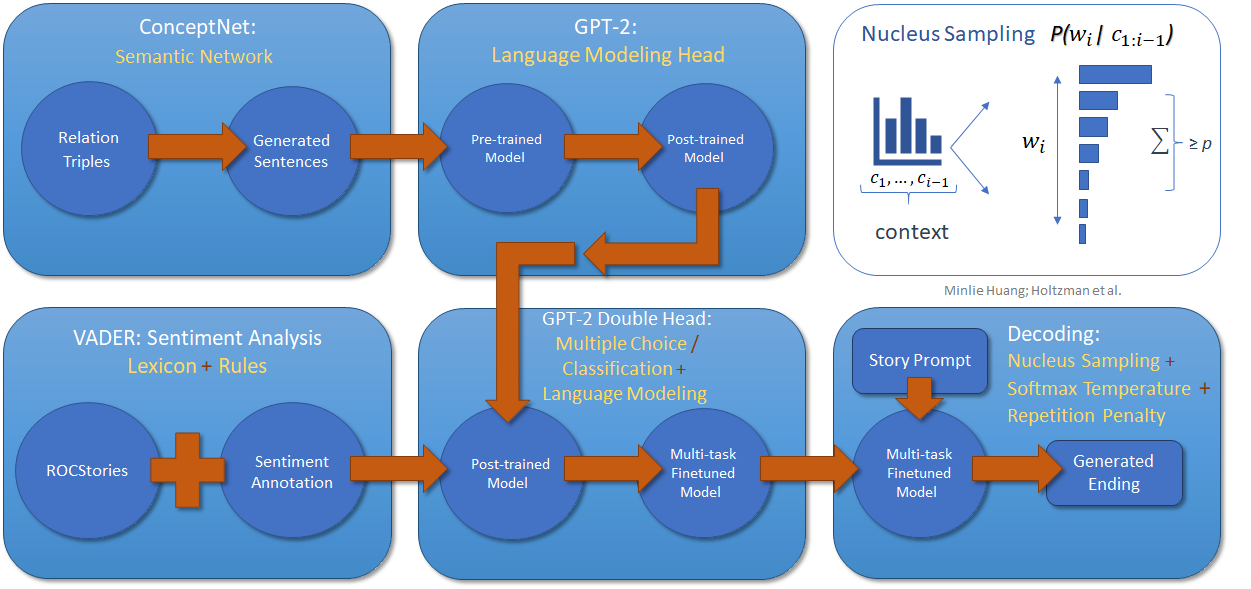

### A. Load data, models

#### 1) Define functions for loading data, models.

In [ ]:
# Load vocabulary, weights from pretrained model(s), set evaluation mode and select device.
def get_model_gen(mpath: str='', typ: str='2', dev: str='cuda'):
    """Get subclassed model, tokenizer from pretrained."""
    logging.basicConfig(level=logging.INFO)
    tokenizer = GPT2Tokenizer.from_pretrained(mpath)
    if typ == "2":
        model = GPT2DoubleHeadsModelRP.from_pretrained(mpath, 
                                                       output_attentions=True)
    else:
        model = GPT2LMHeadModelRP.from_pretrained(mpath)
    model.eval() # deactivate dropout for reproducibility
    model.to(dev)
    return tokenizer, model

# For loading and processing ROCStories data file for generation prompts.
def load_rocstories_dataset(dataset_path: str) -> list:
    """Output story, ending w/ special tokens."""
    sop = "_start_"
    eop = "_delimiter_"
    roc_df = pd.read_csv(dataset_path, sep=',', usecols=[2, 3, 4, 5, 6])
    df_endings = roc_df.sentence5
    df_stories = roc_df.loc[:, :'sentence4'].copy()
    story_bodies = df_stories.sentence1 + " " + df_stories.sentence2 + " " + df_stories.sentence3 + " " + df_stories.sentence4
    df_stories.sentence1 = sop + df_stories.sentence1
    df_stories.sentence4 = df_stories.sentence4 + eop
    return story_bodies, df_stories, df_endings

def model_c(model: str) -> str:
    """For choosing model via dropdown."""
    return model

def load_res(mname: str) -> list:
    """Load results as DataFrame."""
    df = pd.read_csv(f"stories/seg_results_{mname}.txt", sep='\t', error_bad_lines=False)
    return df

#### 2) Choose model, set path for test dataset to use for prompts, correct endings.

In [ ]:
model_chooser = interactive(model_c, model=[('Base', 'gpt2'),
                                            ('Base to ConceptNet', 'conceptnet'),
                                            ('Base to ROC', 'roc1617'),
                                            ('Base to SCT', 'b_SCT'),
                                            ('Base to SCT to Sentiment', 'b_SCT_sentiment'),
                                            ('ConceptNet to SCT', 'cn_SCT'),
                                            ('ConceptNet to Sentiment', 'cn_sentiment'),
                                            ('CN to SCT to Sentiment', 'cn_SCT_sentiment'),
                                            ('CN to Sentiment to SCT', 'cn_sentiment_SCT'),
                                            ('ROC to SCT to Sentiment', 'roc1617_SCT_sentiment'),
                                            ('ROC to Sentiment to SCT', 'roc1617_sentiment_SCT'),
                                            ('ROC to SCT', 'roc1617_SCT')])
display(model_chooser)

interactive(children=(Dropdown(description='model', options=(('Base', 'gpt2'), ('Base to ConceptNet', 'concept…

In [ ]:
if model_chooser.result:
    mname = model_chooser.result
dpath = "datasets/roc_1617_test.csv"

#### 3) Run model data loading functions for generation:

In [ ]:
story_bodies, df_stories, df_endings = load_rocstories_dataset(dpath)
stories = df_stories.join(df_endings).values.tolist()

In [ ]:
if mname == 'gpt2': # For running base model.
    model_path = mname
else:
    model_path = f'models/{mname}'
tokenizer, model = get_model_gen(model_path)

### B. Main generation functions

#### 1) Define functions to generate, collect results, write to files:

In [ ]:
def get_text(prompt, model, tokenizer, add_to_tb, added: bool, mname:str) -> str:
    """Conditionally generate endings with model."""
    n = 53
    if mname == 'gpt2':
        n = 50
        prompt = prompt.replace("_start_", "") \
                       .replace("_delimiter_", "") \
                       .replace("_classify_", "")
    encoded_prompt = tokenizer.encode(prompt, 
                                      add_special_tokens=False, 
                                      return_tensors="pt")
    encoded_prompt = encoded_prompt.to("cuda")
    with torch.no_grad():
        output_sequences = model.generate(
            input_ids=encoded_prompt,
            min_length=6, # Avoid evaluation errors...
            bos_token_id=[tokenizer.bos_token_id, 50258], # _delimiter_
            pad_token_id=50256, # |endoftext|
            max_length=len(prompt.split(" ")) + n, # Give room for final sentence of ~30 tokens past input.
            temperature=0.7,
            eos_token_id=50259, #[50256, 50259, 0, 30, 13], # 50259 _classify_; others: !?.
            top_k=20,
            top_p=0.9,
            repetition_penalty=1.2, # Modified to not punish frequent punctuation.
            do_sample=True,
            decoder_start_token_id=50258)
    if add_to_tb and not added:
        with SummaryWriter(comment='GPT2DoubleHeadsModel') as w:
            w.add_graph(model, encoded_prompt, verbose=False)
            added = True
    text = tokenizer.decode(output_sequences[0], 
                            clean_up_tokenization_spaces=True, 
                            skip_special_tokens=True)
    if not mname == 'gpt2':
        text = text.replace("_start_", "") \
                   .replace("_delimiter_", "") \
                   .replace("_classify_", "")
    else:
        text = text.replace("\n", "")
    return text

def write_stories(subtitle: str, stories: list, df_endings) -> None:
    """Write stories and endings to files."""
    endings = []
    df_endings_list = df_endings.values.tolist()
    with open(f"stories/seg_results_{subtitle}.txt", "w") as results_file:
        results_file.write(
        "Story\tCorrectEnding\tGenEnding\n")
        for ix, story in enumerate(stories):
            story = story.split("\t")
            try:
                gen_end = story[2]
            except:
                gen_end = "_none_"
            results_file.write(story[0] + "\t" + df_endings_list[ix] + "\t" + gen_end + "\n")
            endings.append((df_endings_list[ix], gen_end))
    write_endings(subtitle, endings)

def write_endings(subtitle: str, endings:list) -> None:
    """Write generated endings to file."""
    with open(f"endings/{subtitle}_gen_ends.txt", "w") as gend_file:        
        for ends in endings:
            if ends[1].strip() == "":
                gen_end = "_none_"
            else:
                gen_end = ends[1]
            gend_file.write(gen_end + "\n")
    with open(f"endings/{subtitle}_corr_ends.txt", "w") as cend_file:        
        for ends in endings:
            cend_file.write(ends[0] + "\n")

def get_endings(mname: str, 
                stories: list,
                model, tokenizer,
                add_to_tb = False, ) -> list:
    """Use generation function to collect stories+endings."""
    endings = []
    seg_stories = []
    added = False
    for ix, s in enumerate(stories):
        sb = ' '.join(s[:4])
        text = get_text(sb, model, tokenizer, add_to_tb, added, mname)
        if not mname == 'gpt2':
            results = text.split("  ")
        else: # Stop-gap measure to split off endings sans special tokens. TODO: Use prompt length in get_text instead.
            last = s[-2].replace("_delimiter_", "")
            ix = text.rindex(last)
            end = [text[ix+len(last):].lstrip()]
            results = [text[:ix+len(last)]] + end
        story = results[:-1]
        ends = [s[-1], results[-1]] # Correct, Generated endings
        endings.append(ends)
        story_final = "\t".join(story + ends)
        seg_stories.append(story_final)
    return seg_stories, endings

#### 2) Get results

Run function to generate results from processed ROCStories:

In [ ]:
inter_get_ends = interactive(get_endings, {'manual': True, 
                                           'manual_name': 'Get stories/endings'}, 
                             mname=fixed(mname),
                             stories=fixed(stories), 
                             model=fixed(model), 
                             tokenizer=fixed(tokenizer),
                             add_to_tb=False) # Add graph to TensorBoard.

#inter_get_ends.layout.height = '250px'
display(inter_get_ends)

interactive(children=(Checkbox(value=False, description='add_to_tb'), Button(description='Get stories/endings'…

Collect generated stories/endings:

In [ ]:
if inter_get_ends.result:
    gen_stories, gen_endings = inter_get_ends.result
#pd.DataFrame(gen_endings).head()

#### 3) Write endings and stories to file (be careful not to unintentionally overwrite):

In [ ]:
inter_stories = interactive(write_stories, {'manual': True, 
                                            'manual_name': 'Stories/Endings to file'}, 
                            subtitle=mname, 
                            stories=fixed(gen_stories), 
                            df_endings=fixed(df_endings))
inter_stories.layout.height = '250px'
display(inter_stories)

interactive(children=(Text(value='cn_SCT_o', description='subtitle'), Button(description='Stories/Endings to f…

#### 4) Load and display results:

Load, display story results from file:

In [ ]:
get_res = interactive(load_res, 
                       {'manual': True, 
                        'manual_name': 'Load results'}, 
                       mname=mname)
display(get_res)

interactive(children=(Text(value='cn_SCT_o', description='mname'), Button(description='Load results', style=Bu…

In [ ]:
res_df = pd.DataFrame()
if get_res:
    res_df = get_res.result
if not res_df.empty:
    display(res_df.head())

Load, display story results from variables:

In [ ]:
res_df = pd.DataFrame(gen_stories)
res_df.head()